In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-04 21:24:39.293122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dev = qml.device('default.mixed', wires=2)

In [3]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)

In [4]:
print(qml.draw(real)())

0: ──Rot(0.00,1.57,0.52)─┤  


In [5]:
def generator(w,**kwargs):
    qml.RZ(w[0], wires=1)
    qml.RX(w[1], wires=1)
    qml.RZ(w[2], wires=1)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=1)

In [6]:
print(qml.draw(generator)([ 0,0,0]))

1: ──RZ(0.00)──RX(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)─┤  


In [7]:
def discriminator(w):
    qml.Hadamard(wires=1)
    qml.CZ(wires=[0, 1])
    qml.RZ(w[0], wires=0)
    qml.RZ(w[1], wires=1)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

In [8]:
print(qml.draw(discriminator)([ 0,1]))

1: ──H─╭Z──RZ(1.00)──H─┤  
0: ────╰●──RZ(0.00)──H─┤  


In [9]:
@qml.qnode(dev, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))
#qml.expval(qml.PauliZ(0) @ qml.PauliX(2))


In [10]:
print(qml.draw(real_gen_disc_circuit)([ 0,0,0,0,0,0,0,0,0],[ 0,1]))

0: ──Rot(0.00,1.57,0.52)──────────────────────────────────────────────╭●──RZ(0.00)──H─┤ ╭<𝓗>
1: ──RZ(0.00)─────────────RX(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)──H─╰Z──RZ(1.00)──H─┤ ╰<𝓗>


In [11]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [12]:
def disc_cost(disc_weights):
    cost = 1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [13]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

2023-06-04 21:24:48.535822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
real_gen_disc_circuit(gen_weights, disc_weights)
#prob_discriminated(gen_weights,disc_weights)

<tf.Tensor: shape=(), dtype=float64, numpy=0.4999999999999999>

In [15]:
@qml.qnode(dev, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev, interface="tf")
def circuit_rs():
    real()
    return qml.state()

In [16]:
loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]
epochs = 10
for i in range(epochs):            
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.5)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step_d.append(step)
            print("Step {}: cost = {}".format(step, loss_val)) 
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.5)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[0])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[1])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
    

Step 0: cost = 0.850876542653979
Step 5: cost = 0.7025731729213578
Step 10: cost = 0.5792043324814009
Step 15: cost = 0.5239942739267823
Step 20: cost = 0.5065775901518432
Step 25: cost = 0.5017498181586421
Step 30: cost = 0.500461698526553
Step 35: cost = 0.5001215563921916
Step 40: cost = 0.5000319850848711
Step 45: cost = 0.5000084149492485
Step 0: cost = 0.4999963404652626
Step 5: cost = 0.499988116490076
Step 10: cost = 0.49996141226491453
Step 15: cost = 0.49987471259939514
Step 20: cost = 0.4995933556466044
Step 25: cost = 0.4986816427204264
Step 30: cost = 0.49574136914343947
Step 35: cost = 0.486403183848892
Step 40: cost = 0.45813928267302084
Step 45: cost = 0.3838623135279239
Step 0: cost = 0.6924071277960684
Step 5: cost = 0.5735199964366676
Step 10: cost = 0.5220363870987406
Step 15: cost = 0.5060203193623072
Step 20: cost = 0.5016000498319402
Step 25: cost = 0.5004220743662191
Step 30: cost = 0.500111116667247
Step 35: cost = 0.5000292375685785
Step 40: cost = 0.500007692

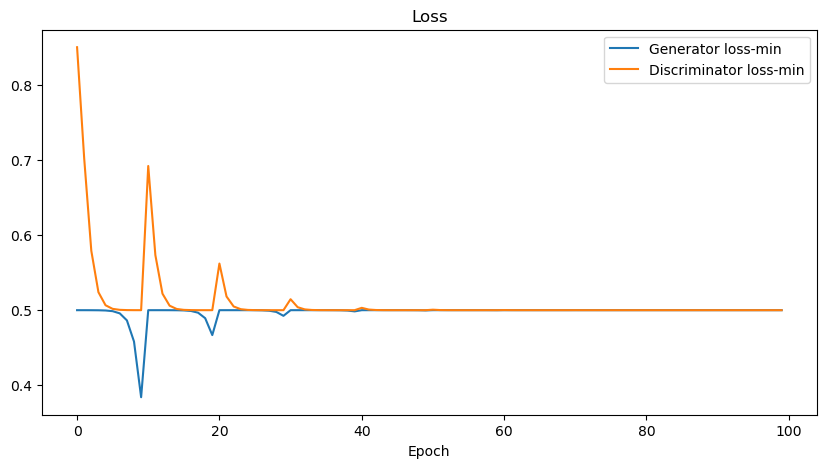

In [17]:
#loss_d = [ 1-x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

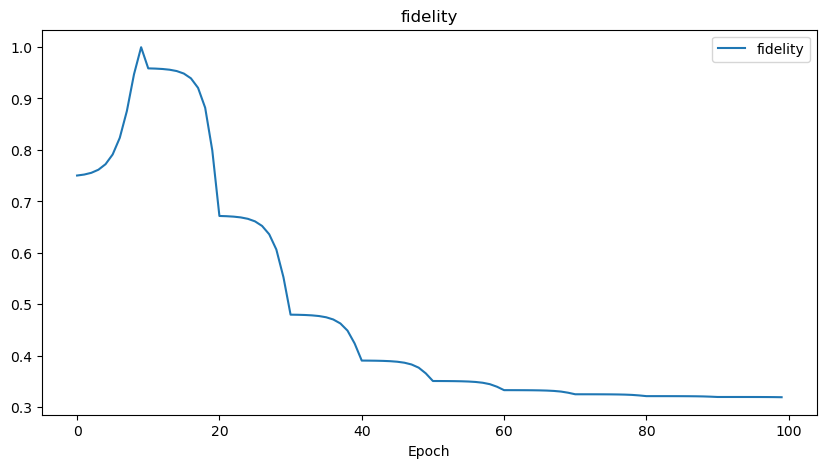

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), sg, label="fidelity")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [19]:
def generator(w,**kwargs):
    qml.RZ(w[0], wires=1)
    qml.RX(w[1], wires=1)
    qml.RZ(w[2], wires=1)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=1)
    qml.BitFlip(0.01, wires=1)
print(qml.draw(generator)([ 0,0,0]))    

1: ──RZ(0.00)──RX(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)──BitFlip(0.01)─┤  


In [20]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]
epochs = 20
for i in range(epochs):            

    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step_d.append(step)
            print("Step {}: cost = {}".format(step, loss_val)) 
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[0])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[1])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
           

Step 0: cost = 0.8574318984845322
Step 5: cost = 0.742573467644448
Step 10: cost = 0.6285385605270951
Step 15: cost = 0.5557237833698414
Step 20: cost = 0.5219675642992304
Step 25: cost = 0.5087322786623373
Step 30: cost = 0.5038960621523798
Step 35: cost = 0.502175208138756
Step 40: cost = 0.5015687099483062
Step 45: cost = 0.5013556778162586
Step 0: cost = 0.49870948871394255
Step 5: cost = 0.4987080212400549
Step 10: cost = 0.4987042328385233
Step 15: cost = 0.4986944529250244
Step 20: cost = 0.49866920667050874
Step 25: cost = 0.49860404160427735
Step 30: cost = 0.4984358830322969
Step 35: cost = 0.49800224259282294
Step 40: cost = 0.4968859342417402
Step 45: cost = 0.49402509707986253
Step 0: cost = 0.5091685075180485
Step 5: cost = 0.5034277610089446
Step 10: cost = 0.5013881442293912
Step 15: cost = 0.5006716663939852
Step 20: cost = 0.5004209875185017
Step 25: cost = 0.5003334038531081
Step 30: cost = 0.500302818367805
Step 35: cost = 0.5002921393036766
Step 40: cost = 0.500288

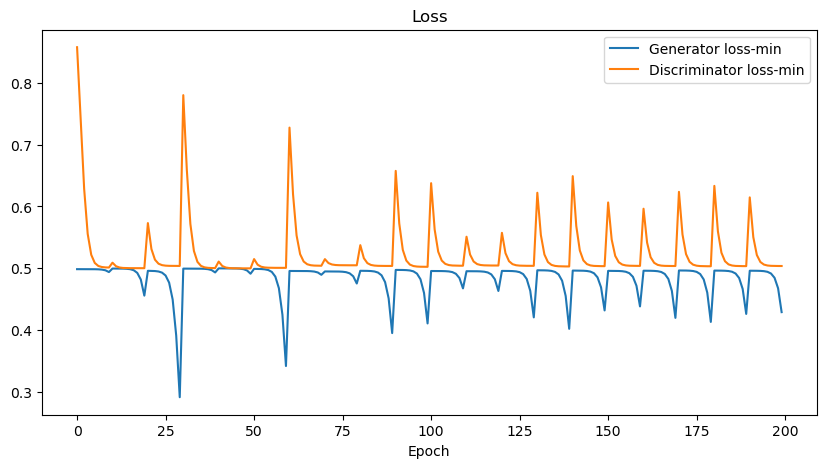

In [21]:
#loss_d = [ 1-x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

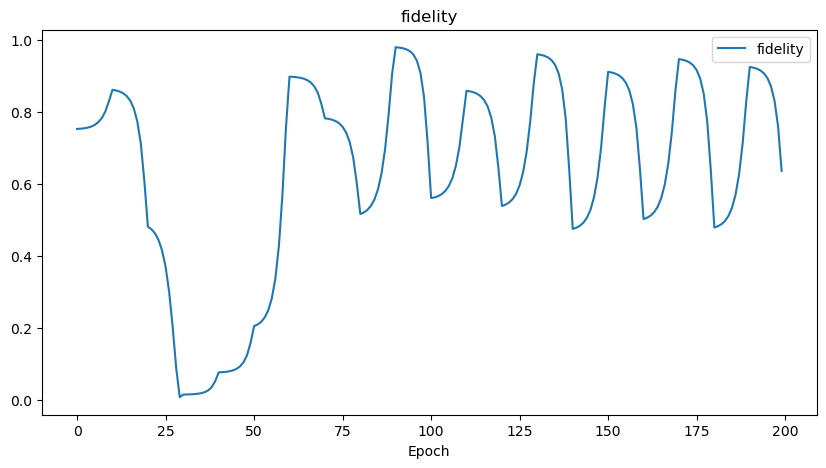

In [22]:
#loss_d = [ 1-x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), sg, label="fidelity")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]
epochs = 2
for i in range(epochs):            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[0])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[1])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step_d.append(step)
            print("Step {}: cost = {}".format(step, loss_val))             